In [1]:
%%capture
## compile PyRoss for this notebook
import os
owd = os.getcwd()
os.chdir('../../')
%run setup.py install
os.chdir(owd)

In [2]:
%matplotlib inline
import numpy as np
import pyross
import pandas as pd
import time 
import matplotlib.pyplot as plt
from scipy.io import loadmat

In [3]:
## population and age classes
M=4  ## number of age classes

my_data = np.genfromtxt('../data/age_structures/UK.csv', delimiter=',', skip_header=1)
aM, aF = my_data[:, 1], my_data[:, 2]

Ni0=aM+aF;   Ni=np.zeros((M))

# scale the population down to a more manageble level 
Ni[0] = (np.sum(Ni0[0:4])).astype('int')
Ni[1] = (np.sum(Ni0[4:8])).astype('int')
Ni[2] = (np.sum(Ni0[8:12])).astype('int')
Ni[3] = (np.sum(Ni0[12:16])).astype('int')
N=np.sum(Ni)
fi = Ni/N 

# Get individual contact matrices
CH0, CW0, CS0, CO0 = pyross.contactMatrix.India()


CH = np.zeros((M, M))
CW = np.zeros((M, M))
CS = np.zeros((M, M))
CO = np.zeros((M, M))

for i in range(16):
    CH0[i,:] = Ni0[i]*CH0[i,:]
    CS0[i,:] = Ni0[i]*CS0[i,:]
    CW0[i,:] = Ni0[i]*CW0[i,:]
    CO0[i,:] = Ni0[i]*CO0[i,:]

    
for i in range(M):
    for j in range(M):
        i1, j1 = i*4, j*4
        CH[i,j] = np.sum( CH0[i1:i1+4,j1:j1+4]  )/Ni[i]
        CW[i,j] = np.sum( CW0[i1:i1+4,j1:j1+4]  )/Ni[i]
        CS[i,j] = np.sum( CS0[i1:i1+4,j1:j1+4]  )/Ni[i]
        CO[i,j] = np.sum( CO0[i1:i1+4,j1:j1+4]  )/Ni[i]
        
N = N/5e2
Ni = Ni/5e2

In [4]:
# Generate class with contact matrix for SIR model with UK contact structure
generator = pyross.contactMatrix.SIR(CH, CW, CS, CO)

In [5]:
times= [20] # temporal boundaries between different contact-behaviour

aW, aS, aO = 0.5, 0.6, 0.6

# prefactors for CW, CS, CO:
interventions = [[1.0,1.0,1.0],      # before first time
                 [aW, aS, aO],       # after first time
                ]         

# generate corresponding contact matrix function
C = generator.interventions_temporal(times=times,interventions=interventions)

In [9]:
beta  = 0.02      # contact rate parameter
gIa   = 1./7            # recovery rate of asymptomatic infectives 
gIs   = 1./7            # recovery rate of symptomatic infectives 
alpha = 0.2              # asymptomatic fraction
fsa   = 0.8               # suppresion of contact by symptomatics


# initial conditions    
Is_0 = np.ones(M)*20
Is_0[1] += 10 #make one group different 
Ia_0 = np.zeros((M))*2
Ia_0[1] += 2 
R_0  = np.zeros((M))
S_0  = Ni - (Ia_0 + Is_0 + R_0)


parameters = {'alpha':alpha,'beta':beta, 'gIa':gIa,'gIs':gIs,'fsa':fsa}
model = pyross.stochastic.SIR(parameters, M, Ni)

contactMatrix=C

# start simulation
Tf=100;  Nf=Tf+1 
data=model.simulate(S_0, Ia_0, Is_0, contactMatrix, Tf, Nf)

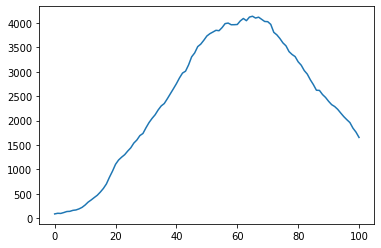

In [10]:
IC  = np.zeros((Nf))
for i in range(M):
        IC += data['X'][:,2*M+i] 
t = data['t']
plt.plot(t, IC)
plt.show() 

-2228.326829986343
0.20928001403808594


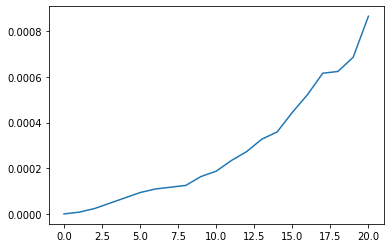

In [11]:
Tf = 20 # truncate to only getting the first few datapoints 
Nf = Tf+1

x = data['X']
x = (x/N)[:Nf]
steps = 101 # number internal integration steps taken, must be an odd number 


# initialise the estimator 
estimator = pyross.inference.SIR(parameters, M, fi, int(N), steps)

# compute -log_p for the original (correct) parameters 
start_time = time.time() 
parameters = {'alpha':alpha, 'beta':beta, 'gIa':gIa, 'gIs':gIs,'fsa':fsa}
logp = estimator.obtain_minus_log_p(parameters, x, Tf, Nf, contactMatrix)
end_time = time.time()
print(logp) 
print(end_time - start_time)

plt.plot(x[:, M])
plt.show()

In [14]:
# take a guess 
eps = 1e-4 # step used to calculate hessian in the optimisation algorithm 
alpha_g = 0.2
alpha_std = 0.1 
alpha_bounds = (eps, 1-2*eps)
# the bound for alpha must be 1-2*eps to avoid alpha>1 in hessian calculation performed by optimizer 

beta_g = 0.04
beta_std = 0.05 
beta_bounds = (eps, 1)

gIa_g = 0.145
gIa_std = 0.1 
gIa_bounds = (eps, 1)

gIs_g = 0.145
gIs_std = 0.1 
gIs_bounds = (eps, 1) 

guess = np.array([alpha_g, beta_g, gIa_g, gIs_g])
stds = np.array([alpha_std, beta_std, gIa_std, gIs_std])
bounds = np.array([alpha_bounds, beta_bounds, gIa_bounds, gIs_bounds])

start_time = time.time() 
params, nit = estimator.inference(guess, stds, x, Tf, Nf, contactMatrix, beta_rescale=5,
                                  niter=4, bounds=bounds, 
                                  eps=eps, verbose=True)
# sometimes produce errors if input is bad, ignore and let basinhopping do its magic
end_time = time.time()
print(params) # best guess 
print(nit) # number of iterations of the optimization run 
print(end_time - start_time)

Starting global minimisation...
(8_w,16)-aCMA-ES (mu_w=4.8,w_1=32%) in dimension 4 (seed=442620, Thu Apr 30 19:19:58 2020)


PicklingError: Can't pickle <cyfunction interventions_temporal.<locals>.C_func at 0x1a251d0d10>: it's not found as pyross.contactMatrix.C_func

In [11]:
aW_g = 0.5 
aW_bounds = [0.1, 0.8]
aS_g = 0.5
aS_bounds = [0.1, 0.8]
aO_g = 0.5
aO_bounds = [0.1, 0.8]
guess = np.array([aW_g, aS_g, aO_g])
bounds = np.array([aW_bounds, aS_bounds, aO_bounds])

x = data['X']/N
x = x[22:]
Nf = x.shape[0] 
Tf = Nf-1 

times = [Tf+1]
interventions = [[aW, aS, aO]]
contactMatrix = generator.interventions_temporal(times=times,interventions=interventions)

# compute -log_p for the initial guess (for the moment, use correct parameters)
logp = estimator.obtain_minus_log_p(parameters, x, Tf, Nf, contactMatrix)
print(logp) 

-2726.660439266943


In [12]:
eps = 1e-3 
start_time = time.time() 

parameters = estimator.make_params_dict(params)
estimator.set_params(parameters) 
params, nit = estimator.infer_control(guess, x, Tf, Nf, generator, bounds,
                                  niter=2, eps=eps, verbose=True)
# sometimes produce errors if input is bad, ignore and let basinhopping do its magic
end_time = time.time()
print(params) # best guess 
print(nit) # number of iterations of the optimization run 
print(end_time - start_time)

parameters: [0.60145273 0.60145273 0.60145273]
parameters: [0.59483025 0.60059908 0.6002705 ]
parameters: [0.56821742 0.60181734 0.60034549]
parameters: [0.54590317 0.60584039 0.60506766]
parameters: [0.53365497 0.60480325 0.61311517]
parameters: [0.53123922 0.60274578 0.61617752]
parameters: [0.52893712 0.59875756 0.61974058]
parameters: [0.52390531 0.58802349 0.62730637]
parameters: [0.51783579 0.57346979 0.63564774]
parameters: [0.5152576  0.56587399 0.63846203]
basinhopping step 0: f -2935.41
parameters: [0.42870566 0.52742992 0.61399739]
parameters: [0.46284837 0.56415368 0.65986096]
parameters: [0.46383371 0.55945257 0.65549303]
parameters: [0.47004467 0.55492619 0.6526796 ]
parameters: [0.48778195 0.54745789 0.64973355]
parameters: [0.50373589 0.54544405 0.64964117]
parameters: [0.50704554 0.54693246 0.64955576]
parameters: [0.50785925 0.54809183 0.64924027]
parameters: [0.50923929 0.55070596 0.64811382]
parameters: [0.51186721 0.55614    0.64516519]
parameters: [0.51521867 0.56